In [1]:
import torch 
bs, nr, nc = 1000, 20, 30
costsBatch = torch.randn(bs, nr, nc).flatten()

warpSize = 32
blockSize = (nr + warpSize - 1) // warpSize
gridSize = (bs * nr + blockSize - 1) // blockSize

def fillWith(substrate, value, startIdx, howMany):
    for i in range(startIdx, startIdx + howMany):
        substrate[i] = value

def copyTo(substrate, source, startIdx, howMany, ):
    for i in range(startIdx, startIdx + howMany):
        substrate[i] = source[i]

def solve_linear_assignment(
        gridSize, blockSize, 
        bs, nr, nc,
        costsBatch,
        col4rowOut,
        row4colOut):
    for blockIdx in range(gridSize):
        costsSize = nr * nc
        costs = costsBatch[blockIdx * costsSize: (blockIdx + 1) * costsSize] # local
        u = torch.zeros(nr) # shared vector
        v = torch.zeros(nc) # shared vector
        col4row = torch.full((nr,), -1)
        row4col = torch.full((nc,), -1)
        col4rowOut[nr * blockIdx: (nr + 1) * blockIdx] = col4row
        row4colOut[nc * blockIdx: (nc + 1) * blockIdx] = row4col


In [ ]:
import cugraph as cg
import cudf
import numpy as np

def hungarian_cugraph(cost_matrix):
    """
    GPU-accelerated Hungarian algorithm using cuGraph's maximum bipartite matching
    
    Args:
        cost_matrix: 2D numpy/cupy array representing assignment costs
        
    Returns:
        Tuple of (total_cost, assignments)
    """
    # Convert cost matrix to a bipartite graph representation
    n = cost_matrix.shape[0]
    
    # Create dataframe for edges (we'll invert weights since we want minimum cost)
    sources = []
    destinations = []
    weights = []
    
    for i in range(n):
        for j in range(n):
            sources.append(i)
            destinations.append(n + j)  # Second partition starts at n
            weights.append(-cost_matrix[i,j])  # Negative for min-cost via max-weight
            
    df = cudf.DataFrame({
        'src': sources,
        'dst': destinations,
        'weight': weights
    })
    
    # Create bipartite graph
    G = cg.Graph()
    G.from_cudf_edgelist(
        df,
        source='src',
        destination='dst',
        edge_attr='weight',
        renumber=False
    )
    
    # Find maximum weight matching (equivalent to min-cost)
    matching = cg.matching.maximum_weight_matching(G)
    
    # Process results
    assignments = [-1] * n
    total_cost = 0.0
    
    for i in range(len(matching)):
        if matching['vertex'][i] < n:  # Only consider assignments from first partition
            worker = matching['vertex'][i]
            job = matching['match'][i] - n
            assignments[worker] = job
            total_cost += cost_matrix[worker, job]
    
    return total_cost, assignments

In [1]:
import torch 

costs_tr1 = torch.load('/root/torch-linear-assignment/experiments/linear-assignment-matrices/costs-train1.pth')

In [2]:
costs_tr1.size()

torch.Size([20064, 32, 32])

In [3]:
costs_tr2 = torch.load('/root/torch-linear-assignment/experiments/linear-assignment-matrices/costs-train2.pth')
costs_tr2.size()

torch.Size([20368, 32, 32])

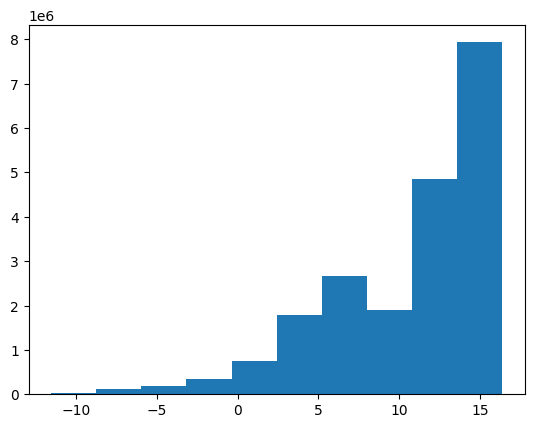

In [4]:
import matplotlib.pyplot as plt 

plt.hist(costs_tr1.flatten().numpy());

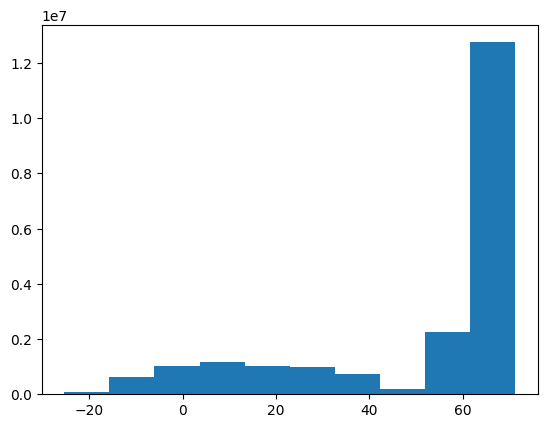

In [5]:
plt.hist(costs_tr2.flatten().numpy());

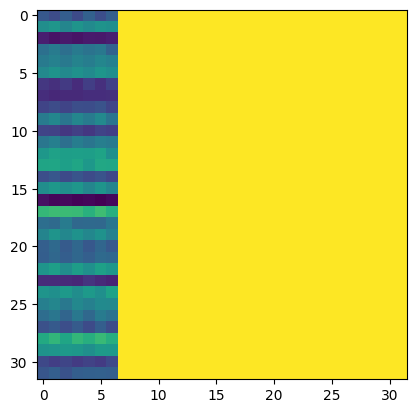

In [6]:
plt.imshow(costs_tr2[4].numpy())

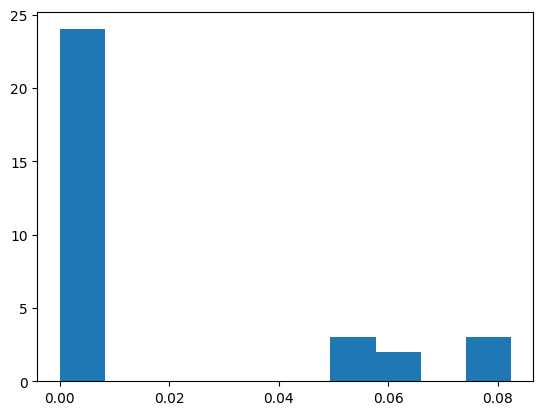

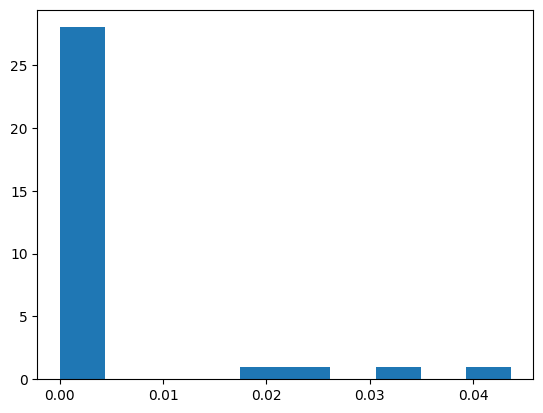

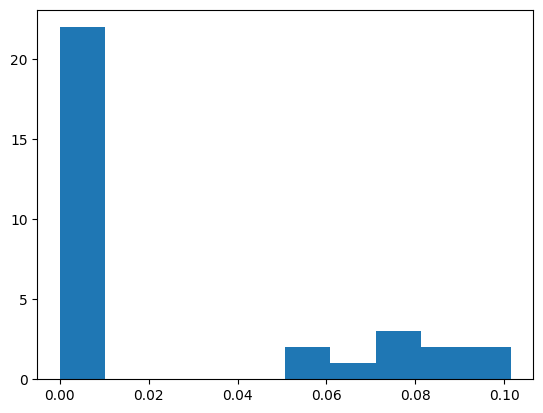

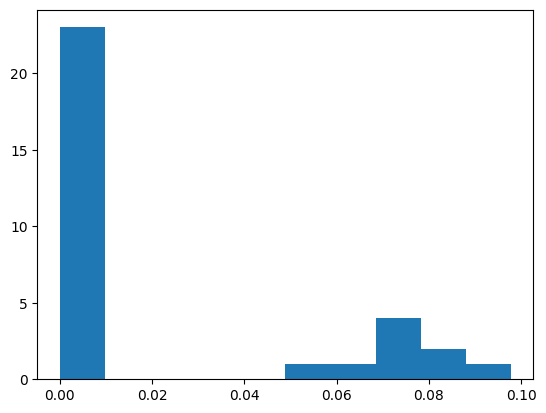

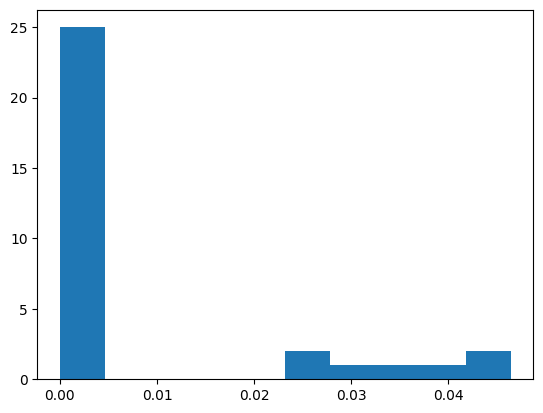

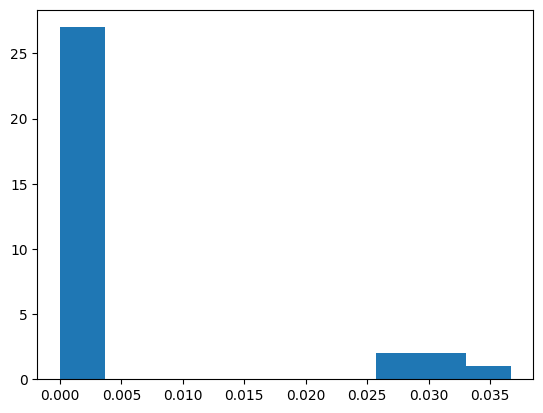

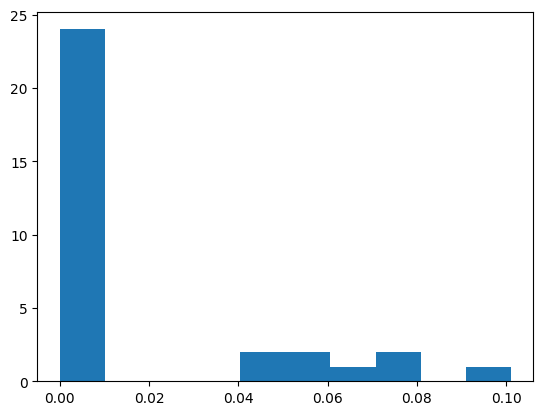

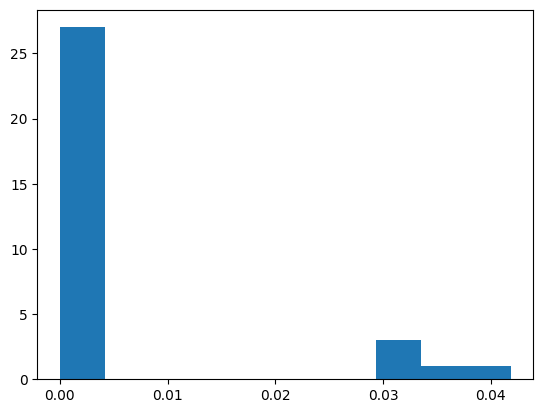

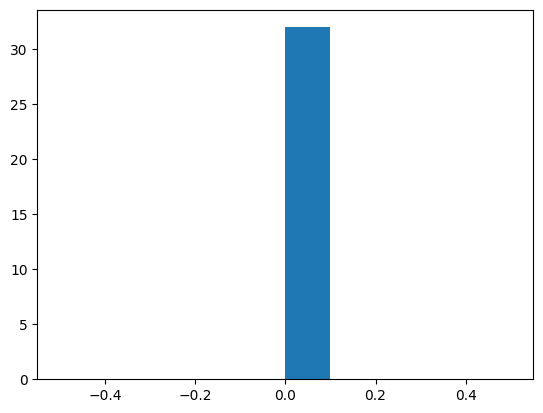

In [8]:
def filter_cost(cost):
    fill_val = cost[-1, -1]
    idxx = (cost != fill_val).sum(0)[0]
    idxy = (cost != fill_val).sum(1)[0]
    filtered_cost = cost[:idxy, :idxx]
    return filtered_cost
    

def describe_diversity(cost, ax=-2):
    return (cost.max(ax).values - cost.min(ax).values) / 2 / cost.mean(ax)


filtered = [filter_cost(cost)for cost in costs_tr1]

limit = 10
for i, filt in enumerate(filtered):
    if i >= limit:
        break
    if not all(filt.size()):
        continue

    plt.hist(
    describe_diversity(filt),
    );
    plt.show()

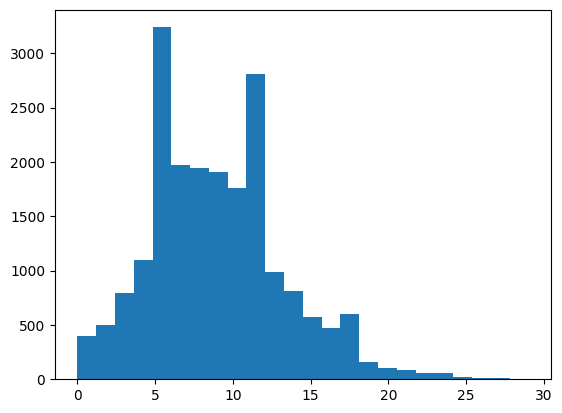

In [ ]:
plt.hist(
    [filter_cost(cost).size(-2) for cost in costs_tr2],
    bins=24
);

In [ ]:
[filter_cost(cost).size(-2) for cost in costs_tr2]

In [15]:
costs_te1 = torch.load('/root/torch-linear-assignment/experiments/linear-assignment-matrices/costs-test1.pth')
costs_te1.size()

torch.Size([12518, 32, 24])

In [16]:
costs_te2 = torch.load('/root/torch-linear-assignment/experiments/linear-assignment-matrices/costs-test2.pth')
costs_te2.size()

torch.Size([3200, 64, 32])